In [2]:
import os

import numpy as np
from numpy import sqrt as sqrt
from numpy import pi as pi

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit as cf

In [3]:
c0 = 299792458

def bin_data(xs, ys, res):
    xs_binned = np.zeros(int(xs.size//res))
    ys_binned = np.zeros_like(xs_binned)
    
    for i in range(int(xs.size//res)-1):
        xs_binned[i] = np.mean(xs[res*i:res*i+1])
        ys_binned[i] = np.mean(ys[res*i:res*i+1])
    
    xs_binned[-1] = np.mean(xs[-int(xs.size%res):-1])
    ys_binned[-1] = np.mean(ys[-int(xs.size%res):-1])
    
    return xs_binned, ys_binned

[ 0.88086579 13.97021867 55.79682329]


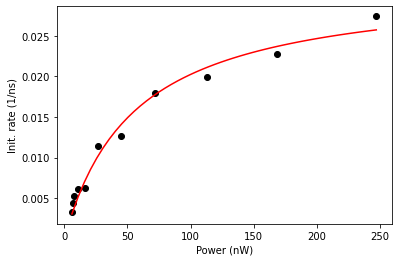

In [4]:
def Gamma_init(P, Gamma, eta, Psat):
    return Gamma/2 * P/Psat/(1+ P/Psat) * 1/eta

# Data taken from 22.11.2022 where the spin initialization rate was measured
data = np.array([[6, 0.003257329],
[7, 0.004424779],
[8, 0.005291005],
[11, 0.006134969],
[16, 0.00621118],
[27, 0.011389522],
[45, 0.012594458],
[72, 0.017985612],
[113, 0.019920319],
[168, 0.022779043],
[247, 0.02739726]])
Ps = data[:,0]
Gamma_inits = data[:,1]
plt.plot(Ps, Gamma_inits, 'ok')
plt.xlabel("Power (nW)")
plt.ylabel("Init. rate (1/ns)")

bounds = [(0.090, 1, 1), (1, 100, 200)]
popt, pcov = cf(Gamma_init, Ps, Gamma_inits, bounds=bounds)
plt.plot(np.linspace(min(Ps), max(Ps)), Gamma_init(np.linspace(min(Ps), max(Ps)), *popt), '-r')
print(popt)

In [5]:
def moving_average(x, N):
    return np.convolve(x, np.ones(N)/N, mode='valid')

def gaussian(x, mu, sigma, A, c):
    return A*1/np.sqrt(2*pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2)) + c

def double_gaussian(x, mu1, mu2, sigma1, sigma2, A1, A2, c):
    return gaussian(x, mu1, sigma1, A1, c) + gaussian(x, mu2, sigma2, A2, c)

def histo(x, bins=10):
    hist, bin_edges = np.histogram(x, bins=bins)
    bin_ctrs = 0.5*(bin_edges[1:] + bin_edges[:-1])
    return bin_ctrs, hist

def clean_wavemeter(lbds, plot=False):
    d_lbds = np.diff(np.abs(lbds))
    
    N_avg = 4
    bin_ctrs, hist = histo(np.abs(moving_average(d_lbds, N_avg)), 500)
    p0 = (np.median(bin_ctrs), 
      np.median(bin_ctrs), 
      np.amax(hist),
      0)
    popt, pcov = cf(gaussian, bin_ctrs, hist, p0=p0)
    (mu, sigma, A, c) = popt
#     print(1/len(popt)*np.sqrt(np.sum(np.power(np.sqrt(np.diag(pcov))/popt,2))))
    mask = np.argwhere(np.abs(moving_average(d_lbds, N_avg)) > mu - 5*sigma).flatten()
    if plot:
        fig, axs = plt.subplots(2,1)
        axs[0].plot(lbds, '-b')    
        axs[0].twinx().plot(np.diff(lbds), '-k')
        axs[0].twinx().plot(moving_average(d_lbds, N_avg), '-r')

        axs[1].plot(bin_ctrs, hist)
        axs[1].plot(bin_ctrs, gaussian(bin_ctrs, *popt))
        plt.show()
    return mask

7 [1.54890532e-01 2.79644200e+02 1.61428631e+01]


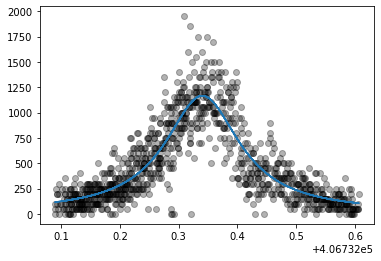

9 [1.72654367e-01 3.51340897e+02 6.71489210e-12]


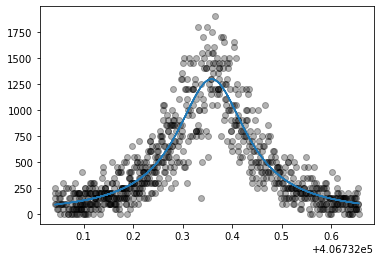

11 [1.83871117e-01 3.36847714e+02 4.84074075e+00]


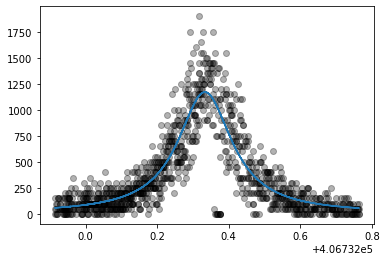

13 [2.01510161e-01 4.42972477e+02 1.99342915e+00]


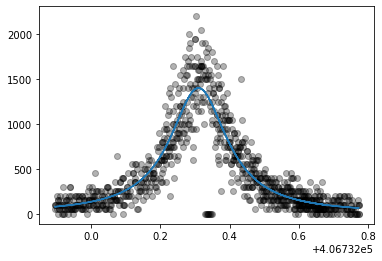

16 [2.18738750e-01 5.16813241e+02 1.53268921e-07]


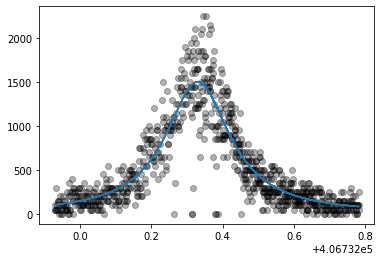

27 [2.53702459e-01 7.20573581e+02 1.99248191e+01]


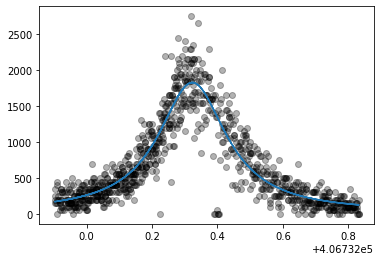

46 [2.79751412e-01 9.12892820e+02 4.15932051e+01]


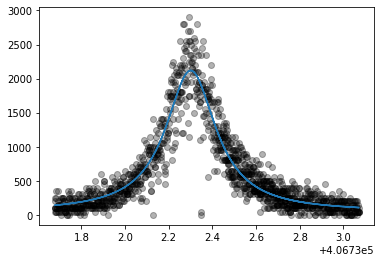

73 [3.28646177e-01 1.03050239e+03 3.56504351e+01]


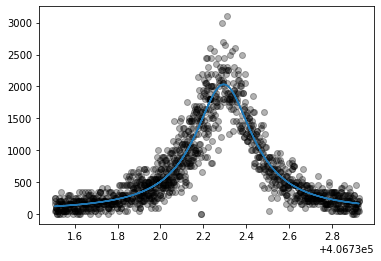

114 [4.23336913e-01 1.58920539e+03 1.05232654e+02]


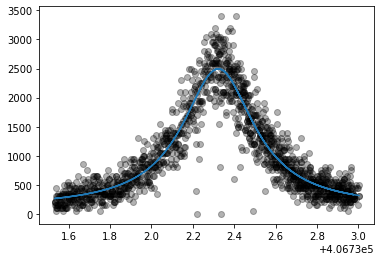

168 [5.33223948e-01 2.09203647e+03 6.95211885e+01]


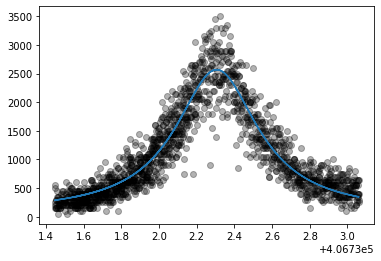

<function __main__.<lambda>(P, A, c)>

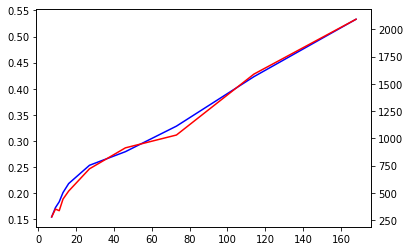

In [16]:
def lorentzian(Delta, Delta0, Gamma, A, c):
    return A * 2/(np.pi*Gamma) * (Gamma/2)**2/((Delta - Delta0)**2+(Gamma/2)**2) + c

def Gamma_opt(Delta, Delta0, Gamma, A, c, alpha):
    Omega = alpha * np.sqrt(P)
    return A*Gamma/2 * 2*(Omega/Gamma)**2/(1+(2*(Delta-Delta0)/Gamma)**2 + 2*(Omega/Gamma)**2) + c

Ps = np.array([
    7,
9,
11,
13,
16,
27,
46,
73,
114,
168
])
files = [
    '20221122-1420-08_wavemeter_log_counts_with_wavelength.dat',
'20221122-1419-13_wavemeter_log_counts_with_wavelength.dat',
'20221122-1418-35_wavemeter_log_counts_with_wavelength.dat',
'20221122-1417-26_wavemeter_log_counts_with_wavelength.dat',
'20221122-1410-45_wavemeter_log_counts_with_wavelength.dat',
'20221122-1411-33_wavemeter_log_counts_with_wavelength.dat',
'20221122-1412-24_wavemeter_log_counts_with_wavelength.dat',
'20221122-1413-09_wavemeter_log_counts_with_wavelength.dat',
'20221122-1414-06_wavemeter_log_counts_with_wavelength.dat',
'20221122-1415-04_wavemeter_log_counts_with_wavelength.dat'
]

Gamma_opts = []
alphas = []
As = []
for P, file in zip(Ps, files):
    data = np.genfromtxt(os.path.join(r'Data\Wavemeter\20221122',file))    
    lbds = data[:,2]
    cts = data[:,1]
    mask = clean_wavemeter(lbds)
    
    nus = c0/lbds[mask]
    cts = cts[mask]
    plt.plot(nus, cts, 'ok', alpha=0.3)

    p0 = (np.median(nus), 0.1, 3.5e4, np.amin(cts))
    bounds = [(np.amin(nus,), 0.085, 0, 0),
              (np.amax(nus), 1, np.inf, np.inf)
             ]
    popt, pcov = cf(lorentzian, nus, cts, p0=p0, bounds=bounds)
    Delta0, Gamma, A, c = popt
    Gamma_opts.append(Gamma)
    As.append(A)    
    print(P, popt[1:])
    plt.plot(nus, lorentzian(nus, *popt))
    plt.show()